# Capstone Project – The Battle of Neighborhoods | Finding a Better Place in Scarborough, Toronto

### 1. Installing and Importing Python Libraries and Dependencies

In [1]:
!pip install geocoder
!pip install folium

Importing Libraries

In [2]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


### 2.  Data Extraction and Cleaning

Using BeautifulSoup Scraping List of Postal Codes of Given Wikipedia Page. 
Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [3]:
# send the GET request
data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')
#get all the data from the table and covert to pandas Dataframe
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
        
toronto=pd.DataFrame(table_contents)

Converting content of PostalCode HTML table as dataframe

In [4]:
df = toronto.groupby(['PostalCode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [5]:
df.describe()

,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,15,103
top,M3M,North York,"Wexford, Maryvale"
freq,1,24,1


In [6]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.PostalCode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [7]:
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['PostalCode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [9]:
df_2.describe()

,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,15,103
top,M3M,North York,"Wexford, Maryvale"
freq,1,24,1


In [10]:
print(df_2.shape)
df_2.head()

(103, 3)


,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [11]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.709020000000066, -79.36348999999996]

In [12]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['PostalCode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [13]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [14]:
df_2[df_2.PostalCode == 'M5G']

,PostalCode,Borough,Neighborhood,Latitude,Longitude
57,M5G,Downtown Toronto,Central Bay Street,43.65609,-79.38493


In [15]:
df_2.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470
3,M1G,Scarborough,Woburn,43.76812,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892
5,M1J,Scarborough,Scarborough Village,43.74446,-79.23117
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.72582,-79.26461
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.71289,-79.28506
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.72360,-79.23496
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.69510,-79.26466


In [16]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="tor_ont")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.7729744, -79.2576479.


### 3. Map of Scarborough

In [17]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [18]:
#Define Foursquare Credentials and Version

CLIENT_ID = '0RZJGCIWCCSICIUILVGITQ3ZH212DBG3MFNQN1WTB54M31EH' # your Foursquare ID
CLIENT_SECRET = 'ZYOKDVPF5WQWDSPZUVDBUXSRXYQHOQUSLA0ALQ3LYNFBMI5R' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0RZJGCIWCCSICIUILVGITQ3ZH212DBG3MFNQN1WTB54M31EH
CLIENT_SECRET:ZYOKDVPF5WQWDSPZUVDBUXSRXYQHOQUSLA0ALQ3LYNFBMI5R


In [19]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_x, 
   longitude_y, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [20]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.events.count',
       'venue.events.summary', 'venue.venuePage.id'],
      dtype='object')

In [21]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 4. Nearby Venues/Locations

In [22]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
2,St. Andrews Fish & Chips,"[{'id': '4edd64a0c7ddd24ca188df1a', 'name': 'F...",43.771865,-79.252645
3,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775512,-79.258288
4,Shoppers Drug Mart,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",43.773305,-79.251662


### 5. Categories of Nearby Venues/Locations

In [23]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,American Eagle Store,Clothing Store,43.776012,-79.258334
2,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645
3,SEPHORA,Cosmetics Shop,43.775512,-79.258288
4,Shoppers Drug Mart,Pharmacy,43.773305,-79.251662


In [24]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store      9
Restaurant          5
Coffee Shop         4
Sandwich Place      2
Pharmacy            2
Toy / Game Store    2
Department Store    2
Gas Station         2
Intersection        2
Wings Joint         1
Name: categories, dtype: int64

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Don Mills South
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth  East
The Danforth West, Riverdale


In [27]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 313 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,21,21,21,21,21,21
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",14,14,14,14,14,14
Bayview Village,6,6,6,6,6,6
"Bedford Park, Lawrence Manor East",27,27,27,27,27,27


### One Hot Encoding of Features

In [28]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Zoo Exhibit,Accessories Store,Adult Boutique,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Newsagent,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarke

In [29]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
            venue  freq
0   Shopping Mall  0.10
1        Pharmacy  0.05
2  Clothing Store  0.05
3            Bank  0.05
4     Coffee Shop  0.05


---- Alderwood, Long Branch ----
            venue  freq
0  Sandwich Place  0.14
1     Pizza Place  0.14
2      Print Shop  0.14
3             Pub  0.14
4     Gas Station  0.14


---- Bathurst Manor, Wilson Heights, Downsview North ----
                       venue  freq
0                       Park  0.14
1                Coffee Shop  0.14
2  Middle Eastern Restaurant  0.07
3               Intersection  0.07
4   Mediterranean Restaurant  0.07


---- Bayview Village ----
                        venue  freq
0            Asian Restaurant  0.17
1  Construction & Landscaping  0.17
2                     Dog Run  0.17
3                       Trail  0.17
4                        Park  0.17


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0  Italian Restaurant  0.11
1         Coffee Shop  0.07
2      Sandwi

                  venue  freq
0           Coffee Shop  0.09
1            Restaurant  0.06
2  Fast Food Restaurant  0.06
3                Bakery  0.06
4               Brewery  0.06


---- Islington Avenue ----
               venue  freq
0           Pharmacy  0.17
1  Convenience Store  0.08
2       Skating Rink  0.08
3               Café  0.08
4      Shopping Mall  0.08


---- Kennedy Park, Ionview, East Birchmount Park ----
                venue  freq
0   Convenience Store  0.17
1    Department Store  0.17
2  Chinese Restaurant  0.17
3      Discount Store  0.17
4         Bus Station  0.17


---- Kensington Market, Chinatown, Grange Park ----
                           venue  freq
0                           Café  0.08
1  Vegetarian / Vegan Restaurant  0.06
2                            Bar  0.05
3                    Coffee Shop  0.04
4            Arts & Crafts Store  0.03


---- Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens ----
                 venue  freq
0   

4      Moving Target  0.00


---- Westmount ----
                       venue  freq
0                Pizza Place  0.13
1                Gas Station  0.13
2  Middle Eastern Restaurant  0.07
3                Golf Course  0.07
4                Coffee Shop  0.07


---- Weston ----
            venue  freq
0   Train Station  0.17
1  Breakfast Spot  0.08
2     Pizza Place  0.08
3        Pharmacy  0.08
4           Diner  0.08


---- Wexford, Maryvale ----
                venue  freq
0          Hookah Bar   0.2
1  African Restaurant   0.2
2         Pizza Place   0.2
3        Burger Joint   0.2
4         Gas Station   0.2


---- Willowdale South ----
                  venue  freq
0           Coffee Shop  0.09
1           Pizza Place  0.06
2            Restaurant  0.05
3  Fast Food Restaurant  0.05
4      Ramen Restaurant  0.05


---- Willowdale West ----
         venue  freq
0      Butcher  0.14
1  Pizza Place  0.14
2         Park  0.14
3  Supermarket  0.14
4     Pharmacy  0.14


---- Willowdale

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most Common venues near neighborhood

In [31]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Pharmacy,Clothing Store,Bank,Coffee Shop,Park,Supermarket,Sushi Restaurant,Skating Rink,Newsagent
1,"Alderwood, Long Branch",Sandwich Place,Pizza Place,Print Shop,Pub,Gas Station,Coffee Shop,Gym,Zoo Exhibit,Music Store,Nightclub
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Coffee Shop,Middle Eastern Restaurant,Intersection,Mediterranean Restaurant,Fried Chicken Joint,Sushi Restaurant,Mobile Phone Shop,Restaurant,Sandwich Place
3,Bayview Village,Asian Restaurant,Construction & Landscaping,Dog Run,Trail,Park,Gas Station,Zoo Exhibit,Office,Nightclub,Newsagent
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Sushi Restaurant,Juice Bar,Thai Restaurant,Greek Restaurant,Grocery Store,Restaurant,Fast Food Restaurant


### K-Means Clustering Approach

In [32]:
# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 0, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0], dtype=int32)

In [33]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()# check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662,2,Zoo Exhibit,Paintball Field,Fast Food Restaurant,Climbing Gym,Music Store,Office,Nightclub,Newsagent,New American Restaurant,Music Venue
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875,1,Bar,Zoo Exhibit,Museum,Office,Nightclub,Newsagent,New American Restaurant,Music Venue,Music Store,Moving Target
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470,0,Park,Gym / Fitness Center,Gymnastics Gym,Athletics & Sports,Zoo Exhibit,Optical Shop,Office,Nightclub,Newsagent,New American Restaurant
3,M1G,Scarborough,Woburn,43.76812,-79.21761,2,Chinese Restaurant,Park,Fast Food Restaurant,Coffee Shop,Zoo Exhibit,Music Venue,Opera House,Office,Nightclub,Newsagent
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892,2,Bank,Lounge,Thai Restaurant,Bakery,Caribbean Restaurant,Hakka Restaurant,Athletics & Sports,Gas Station,Playground,Moving Target


### Map of Clusters

In [34]:
kclusters = 10

In [35]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [36]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [37]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [38]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

<AxesSubplot:xlabel='Neighborhood'>

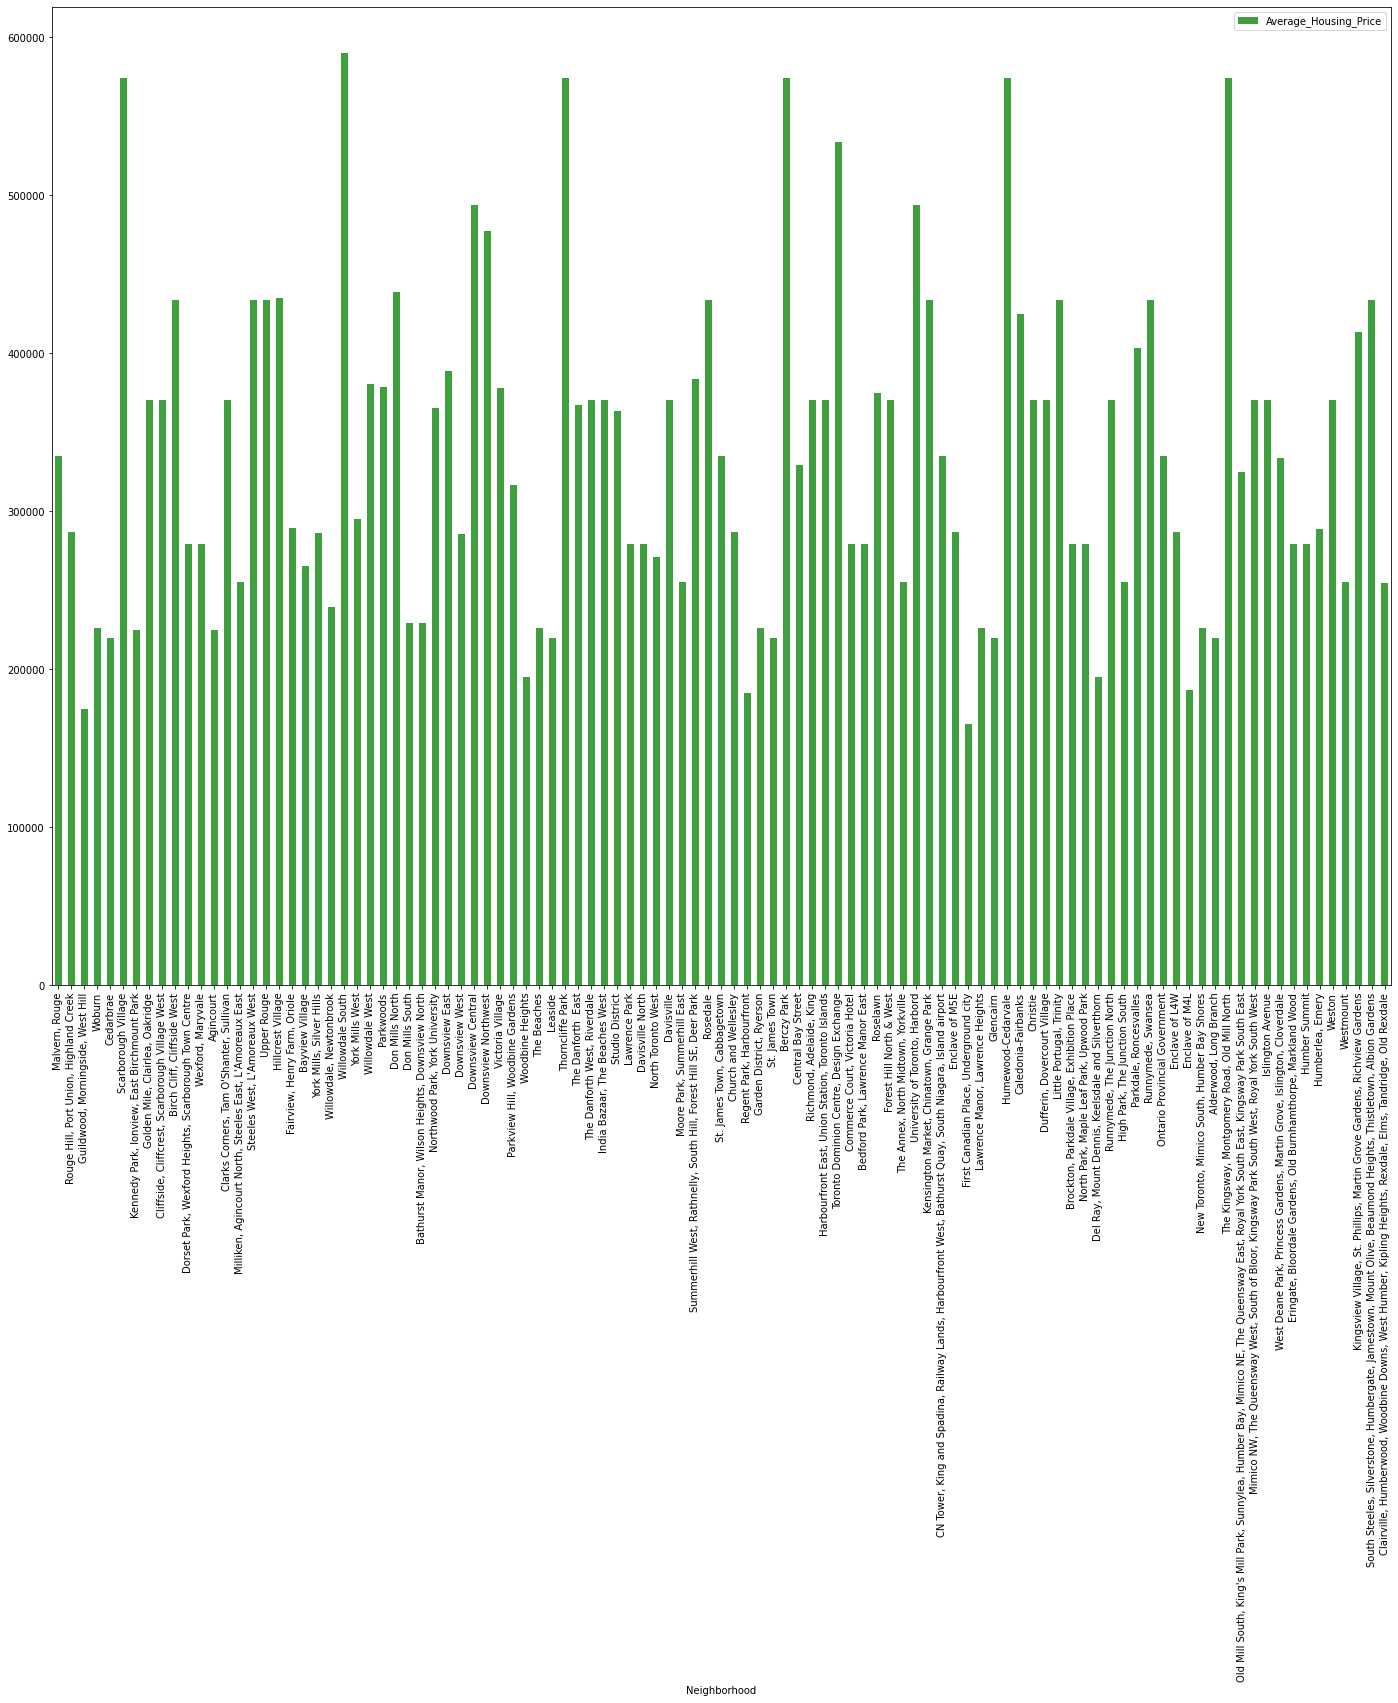

In [39]:
Scarborough_Avg_HousingPrice.plot(kind='bar',color='green',figsize=(24,18),alpha=0.75)

### School Rating by Clusters

In [40]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [41]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [42]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

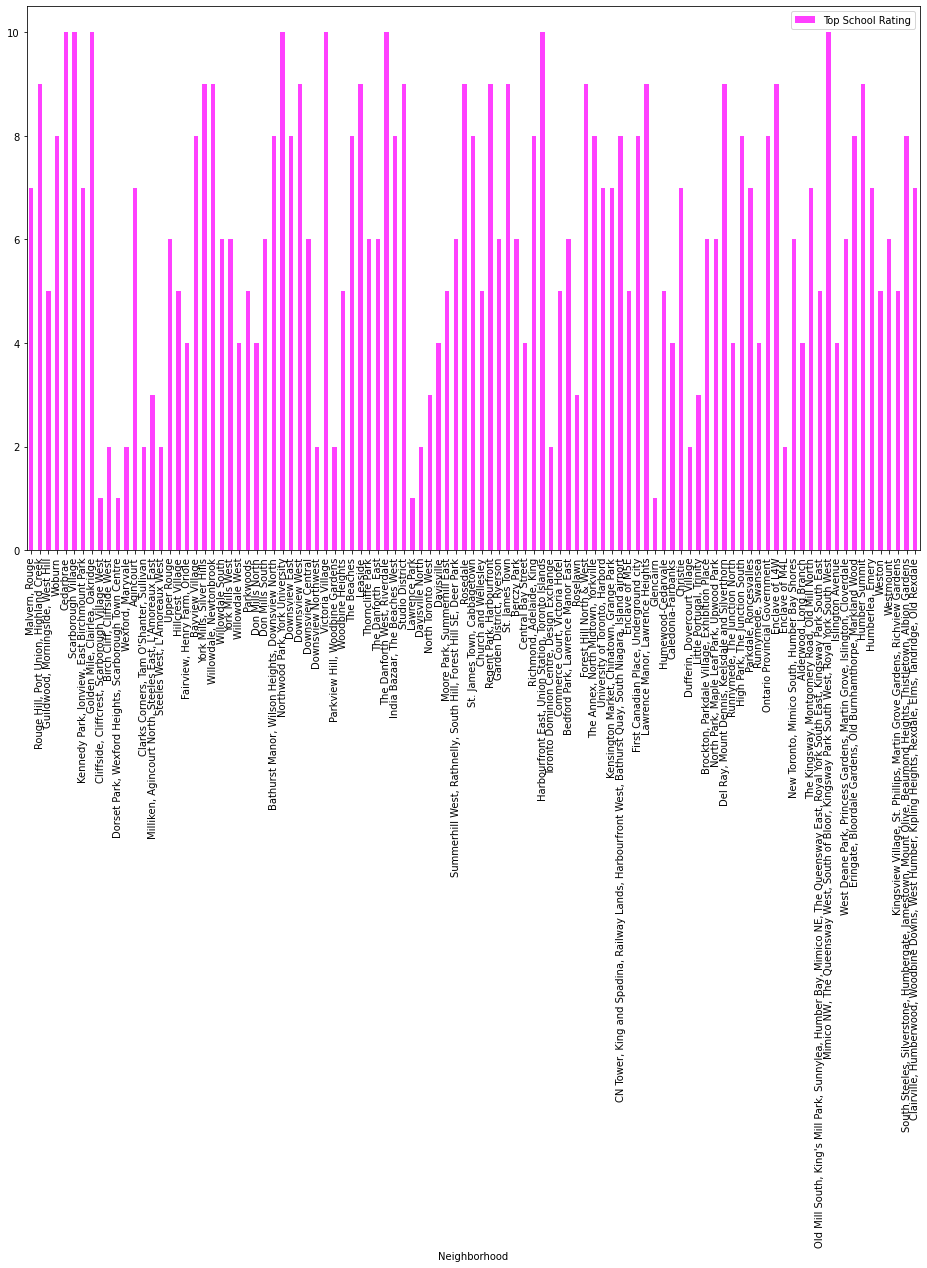

In [43]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='magenta',alpha=0.75);

Conclusion: In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.

#### Thank You! Hope You Liked My Work, I'm Still Learning!
